<span style='color:#0066cc'> <span style='font-family:serif'> <font size="13"> **Accessing MERRA-2 Data with OPeNDAP**<span style='color:#0066cc'>


<span style='color:#0066cc'><font size="5"> **About the "Modern-Era Retrospective analysis for Research and Applications" Version 2 [MERRA-2](https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/docs/) data**
1. <font size="3"><span style='color:Black'> Assimilates observation types not available to its predecessor, MERRA, and includes updates to the Goddard Earth Observing System (GEOS) model and analysis scheme so as to provide a viable ongoing climate analysis beyond MERRA’s terminus.
2. <font size="3"><span style='color:Black'>The Modern-Era Retrospective Analysis for Research and Applications, version 2 (MERRA-2), is the latest atmospheric reanalysis of the modern satellite era produced by NASA’s Global Modeling and Assimilation Office (GMAO).
3. <font size="3"><span style='color:Black'> Other improvements in the quality of MERRA-2 compared with MERRA include the reduction of some spurious trends and jumps related to changes in the observing system and reduced biases and imbalances in aspects of the water cycle.

**Source**: https://doi.org/10.1175/JCLI-D-16-0758.1



<span style='color:#ff6666'><font size="5">**Requirements**
1. <font size="3"><span style='color:Black'> Have a Bearer Token for EarthData in the Cloud (See `GetStarted` Notebook)
2. <font size="3"><span style='color:Black'> Upload the Bearer Token from local file `token.json`

1. <font size="3"><span style='color:Black'>  Or alternatively, use earthaccess to recover the token interactively.


In [1]:
from pydap.net import create_session
from pydap.client import get_cmr_urls, consolidate_metadata, open_url
import xarray as xr
import datetime as dt
import earthaccess
import json
import matplotlib.pyplot as plt

<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Import Token Authorization and create Session**
 


<font size="3.5"> Here we use the Bearer Token to create an authenticated session. The Bearer token can be defined and stored locally, as described in the `GetStarted` Notebook. In the following scenario, we will make of earthaccess



In [2]:
auth = earthaccess.login(strategy="interactive", persist=True) # you will be promted to add your EDL credentials

# pass Token Authorization to a new Session.
cache_kwargs={'cache_name':'MERRA2'}
my_session = create_session(use_cache=True, session=auth.get_session(), cache_kwargs=cache_kwargs)
my_session.cache.clear()

<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Query opendap urls using NASA's CMR API**

In [3]:
merra2_doi = "10.5067/VJAFPLI1CSIV" # available e.g. GES DISC MERRA-2 documentation 
                                    # https://disc.gsfc.nasa.gov/datasets/M2T1NXSLV_5.12.4/summary?keywords=MERRA-2

<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Filter data via Temporal Searches**

<font size="3.5"> Users can specify date ranges  NASA's CMR can 

<font size="3.5"> There are two ways to specify formats.

    1. Using `python`'s datetime package. It follows the `year-month-day` formatting
    2. A string with the following format: YYYY-MM-DDTHH:MM:SSZ


In [4]:
time_range=[dt.datetime(2023, 1, 1), dt.datetime(2023, 1, 31)] # One month of data

In [5]:
url_limits = 100 # controls the max number of urls returns. Default is 50

In [6]:
urls = get_cmr_urls(doi=merra2_doi,time_range=time_range, limit=url_limits) # you can incread the limit of results
len(urls)

31

### You can inspect OPeNDAP's server data request form by clicking on each individual data url.

You will need to add a `.dmr` to the url before using it on the browser


In [7]:
urls[:2]

['https://opendap.earthdata.nasa.gov/collections/C1276812863-GES_DISC/granules/M2T1NXSLV.5.12.4%3AMERRA2_400.tavg1_2d_slv_Nx.20230101.nc4',
 'https://opendap.earthdata.nasa.gov/collections/C1276812863-GES_DISC/granules/M2T1NXSLV.5.12.4%3AMERRA2_400.tavg1_2d_slv_Nx.20230102.nc4']

<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Server-side Metadata reduction**

<font size="3.5"> Many of NASA's files contain too many variables, beyond those of interest, and processing their metadata can add unnecessary time to data analysis workflows. Below, we use pydap directly to add query parameters (Constraint Expressions) that instruct the remote NASA OPeNDAP server which variables of interest we need.


In [8]:
new_urls = [url.replace("https", "dap4") for url in urls] # 

In [9]:
pyds = open_url(new_urls[0], session=my_session)

In [10]:
print("All variables within dataset: \n", list(pyds.variables()))

All variables within dataset: 
 ['lon', 'time', 'lat', 'TROPPB', 'T2M', 'TQL', 'T500', 'TOX', 'U2M', 'U850', 'PS', 'V850', 'OMEGA500', 'H250', 'Q250', 'T2MDEW', 'PBLTOP', 'V250', 'CLDPRS', 'V50M', 'Q500', 'DISPH', 'H1000', 'TO3', 'TS', 'T10M', 'TROPPT', 'TQI', 'SLP', 'TROPT', 'U250', 'Q850', 'ZLCL', 'TQV', 'V2M', 'T250', 'TROPQ', 'V10M', 'H850', 'T850', 'U50M', 'U10M', 'QV2M', 'CLDTMP', 'TROPPV', 'H500', 'V500', 'T2MWET', 'U500', 'QV10M']


In [11]:
Keep_vars = ["/T2M", "/U2M", "/V2M", "/SLP"] # this are the variables we want
dims = list(set([dim for var in Keep_vars for dim in pyds[var].dims]))  # retain their dimensions
Keep_vars += dims
CE="?dap4.ce=" + (';').join(Keep_vars) # need to add this to each url

In [12]:
opendap_urls = [url + CE for url in new_urls]
opendap_urls[:2]

['dap4://opendap.earthdata.nasa.gov/collections/C1276812863-GES_DISC/granules/M2T1NXSLV.5.12.4%3AMERRA2_400.tavg1_2d_slv_Nx.20230101.nc4?dap4.ce=/T2M;/U2M;/V2M;/SLP;/lon;/time;/lat',
 'dap4://opendap.earthdata.nasa.gov/collections/C1276812863-GES_DISC/granules/M2T1NXSLV.5.12.4%3AMERRA2_400.tavg1_2d_slv_Nx.20230102.nc4?dap4.ce=/T2M;/U2M;/V2M;/SLP;/lon;/time;/lat']

<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Consolidate metadata**

<font size="3.5"> All URLs belonging to the same Collection share many identical variables and metadata. The following function
reduces redundant metadata


In [13]:
my_session.cache.clear()

In [14]:
%%time
consolidate_metadata(opendap_urls, concat_dim='time', session=my_session, set_maps=True)

datacube has dimensions ['lat[0:1:360]', 'lon[0:1:575]'] , and concat dim: `time`
CPU times: user 577 ms, sys: 239 ms, total: 816 ms
Wall time: 22.8 s


In [15]:
len(my_session.cache.urls())

63

In [17]:
my_session.cache.urls()[:4]

['https://opendap.earthdata.nasa.gov/collections/C1276812863-GES_DISC/granules/M2T1NXSLV.5.12.4%3AMERRA2_400.tavg1_2d_slv_Nx.20230101.nc4.dap?dap4.ce=lat%5B0%3A1%3A360%5D%3Blon%5B0%3A1%3A575%5D&dap4.checksum=true',
 'https://opendap.earthdata.nasa.gov/collections/C1276812863-GES_DISC/granules/M2T1NXSLV.5.12.4%3AMERRA2_400.tavg1_2d_slv_Nx.20230101.nc4.dap?dap4.ce=time%5B0%3A1%3A23%5D&dap4.checksum=true',
 'https://opendap.earthdata.nasa.gov/collections/C1276812863-GES_DISC/granules/M2T1NXSLV.5.12.4%3AMERRA2_400.tavg1_2d_slv_Nx.20230101.nc4.dmr?dap4.ce=%2FT2M%3B%2FU2M%3B%2FV2M%3B%2FSLP%3B%2Flon%3B%2Ftime%3B%2Flat',
 'https://opendap.earthdata.nasa.gov/collections/C1276812863-GES_DISC/granules/M2T1NXSLV.5.12.4%3AMERRA2_400.tavg1_2d_slv_Nx.20230102.nc4.dap?dap4.ce=time%5B0%3A1%3A23%5D&dap4.checksum=true']

<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Create Virtual Aggregated Dataset with Xarray**

<font size="3.5"> Now, you can create a virtually aggregated view of the dataset that is ready to analyze with Xarray and Pydap as an engine.


In [18]:
%%time
ds = xr.open_mfdataset(opendap_urls, engine='pydap', session=my_session, combine='nested', concat_dim="time", chunks={"time":1})
ds

CPU times: user 412 ms, sys: 68.1 ms, total: 480 ms
Wall time: 563 ms


<xarray.Dataset> Size: 5GB
Dimensions:  (time: 744, lat: 361, lon: 576)
Coordinates:
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 6kB 2023-01-01T00:30:00 ... 2023-01-31T23:...
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
Data variables:
    T2M      (time, lat, lon) float64 1GB dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    U2M      (time, lat, lon) float64 1GB dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    SLP      (time, lat, lon) float64 1GB dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    V2M      (time, lat, lon) float64 1GB dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
Attributes: (12/31)
    History:                           Original file generated: Wed Jan 11 21...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Filename:                          MERRA2_400.tavg1_2d_slv_Nx.20230101.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    identifier_product_doi:            10.5067/VJAFPLI1CSIV
    RangeBeginningDate:                2023-01-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2023-01-01
    RangeEndingTime:                   23:59:59.000000
    created:                           2025-01-07T19:36:33Z

<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Making a plot downloads data.**

<font size="3.5"> <span style='color:#ff6666'>**NOTE**<span style='color:black'>: When creating the dataset, we specify a chunking in time. Without this, even just downloading a sime time unit downloads the whole (remote) chunk of data (24 time values). 


CPU times: user 182 ms, sys: 30.7 ms, total: 213 ms
Wall time: 5.54 s


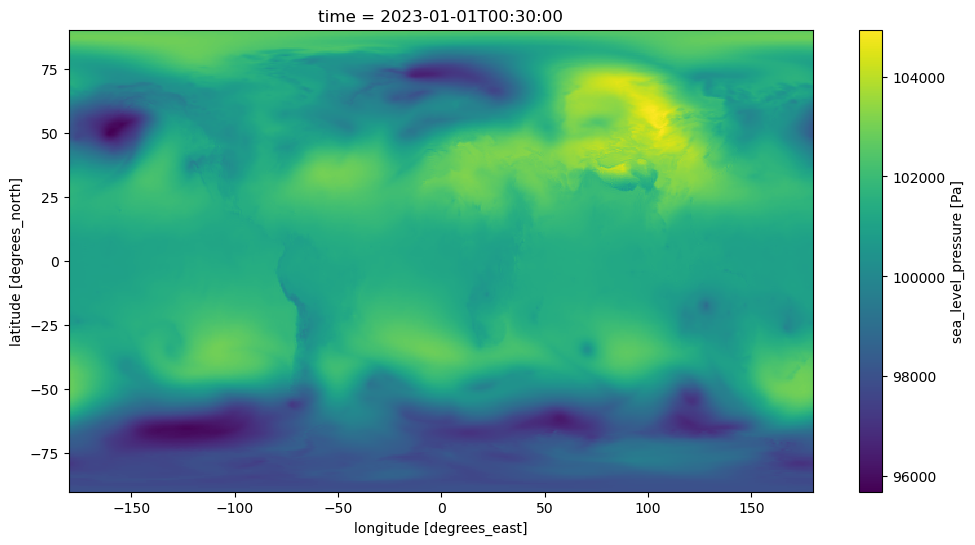

In [19]:
%%time
fig, ax = plt.subplots(figsize=(12, 6))
ds['SLP'].isel(time=0).plot();

<font size="3.5"> You can inspect the OPeNDAP url used by Xarray to download data below:

In [ ]:
my_session.cache.urls()[0].replace("%5B", "[").replace("%5D", "]").replace("%3A", ":") # decoded

<font size="5"> <span style='color:#ff6666'> **dap responses** <span style='color:black'> 

<font size="3.5"> (`.dap`) are OPeNDAP-native, binary-encoded, chunked data streamed over `http` by remote OPeNDAP servers and decoded by `Pydap` to turn them into NumPy arrays. OPeNDAP's `dap` responses are part of the DAP4 protocol and, unlike NetCDF4 datasets, are streamable.